In [1]:
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import sys
import os
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [2]:
from typing import List

class DASTModel():
    def __init__(self, train_dataset_num, train_datasets: List[str], test_dataset: str, data_path: str, hyper_parameters: dict) -> None:
        self.TRAIN_DATASET_NUM = train_dataset_num
        self.TRAIN_DATASETS = train_datasets
        self.TEST_DATASET = test_dataset
        self.DATA_PATH = data_path
        self.X_train_1 = None
        self.Y_train_1 = None
        self.X_train_2 = None
        self.Y_train_2 = None
        self.X_train_3 = None
        self.Y_train_3 = None
        self.X_test = None
        self.Y_test = None
        self.X_train = None
        self.Y_train = None
        self.HP = hyper_parameters
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.best_predict = []
        self.last_predict_y = None
        self.train_loss_list = []
        self.test_loss_list = []
        self.best_mse_loss = 10000.0
        
    @staticmethod
    def RMSE(target, pred):
        square_error = (target - pred) ** 2
        mse =  (torch.sum(square_error)) / len(target)
        rmse = mse ** 0.5
        return rmse
    
    @staticmethod
    def MAE(target, pred):
        absolute_error = np.abs(target - pred)
        return torch.sum(absolute_error) / len(target)
    
    def _load_x_y(self, folder: str):
        y_tmp = np.load(f'{self.DATA_PATH}/{folder}/{folder}_train_Y.npy')
        return np.load(f'{self.DATA_PATH}/{folder}/{folder}_train_X.npy'), np.reshape(y_tmp, ((len(y_tmp), -1)))
    
    def _concate(self):
        self.X_train = np.concatenate((self.X_train_1, self.X_train_2, self.X_train_3), axis=0)
        self.Y_train = np.concatenate((self.Y_train_1, self.Y_train_2, self.Y_train_3), axis=0)

    def _load_np(self,):
        for folder in self.TRAIN_DATASETS:
            dataset_num = folder[-1]
            if dataset_num == '1':
                self.X_train_1, self.Y_train_1 = self._load_x_y(folder)
            elif dataset_num == '2':
                self.X_train_2, self.Y_train_2 = self._load_x_y(folder)
            elif dataset_num == '4':
                self.X_train_3, self.Y_train_3 = self._load_x_y(folder)
        self.X_test = np.load(f'{self.DATA_PATH}/{self.TEST_DATASET}/{self.TEST_DATASET}_test_X.npy')
        self.Y_test = np.load(f'{self.DATA_PATH}/{self.TEST_DATASET}/{self.TEST_DATASET}_test_Y.npy')
        self.Y_test = np.reshape(self.Y_test, (len(self.Y_test), -1))
        
    
    def _select_feature(self, selected_indices):
        self.X_train_1 = [self.X_train_1[:, :, i] for i in selected_indices]
        self.X_train_1 = np.stack(self.X_train_1, axis=-1)
        self.X_train_2 = [self.X_train_2[:, :, i] for i in selected_indices]
        self.X_train_2 = np.stack(self.X_train_2, axis=-1)
        self.X_train_3 = [self.X_train_3[:, :, i] for i in selected_indices]
        self.X_train_3 = np.stack(self.X_train_3, axis=-1)
        self.X_test = [self.X_test[:, :, i] for i in selected_indices]
        self.X_test = np.stack(self.X_test, axis=-1)
        
    def _tensorizing(self):
        self.X_train = Variable(torch.Tensor(self.X_train).float())
        self.Y_train = Variable(torch.Tensor(self.Y_train).float())
        self.X_test = Variable(torch.Tensor(self.X_test).float())
        self.Y_test = Variable(torch.Tensor(self.Y_test).float())
        
    def _get_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.Y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        test_dataset = TensorDataset(self.X_test, self.Y_test)
        test_loader = DataLoader(dataset=test_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        return train_loader, test_loader
    
    def _get_model(self):
        model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['input_size'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], self.HP['debug'])
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.HP['lr'])
        criterion = nn.MSELoss()
        return model, optimizer, criterion
    
    def train(self, model, optimizer: torch.optim.Optimizer, criterion, train_loader: DataLoader, epoch: int):
        model.train()
        tmp_loss_list = []
        loop = tqdm(train_loader, leave=True)
        for _, (X, Y) in enumerate(loop):
            batch_X = X.to(self.device)
            batch_Y = Y.to(self.device)
            out = model(batch_X)
            loss = criterion(out, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss_list.append(loss.item())
        loss_eopch = np.mean(np.array(tmp_loss_list))
        self.train_loss_list.append(loss_eopch)
        print('epoch = ',epoch,
                'train_loss = ',loss_eopch.item())

    def eval(self, model, test_loader: DataLoader, criterion, epoch: int):
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)

        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        if (test_loss.item() < self.best_mse_loss):
            self.best_mse_loss = test_loss.item()
            self.best_predict = np.reshape(out_batch_pre, (-1)).tolist()
        print('rmse_loss = ', rmse_loss.item(),
                'mae_loss = ', mae_loss.item(),
                'mse_loss = ', test_loss.item())
        if epoch == self.HP['epochs'] - 1:
            self.last_predict_y = out_batch_pre
    
    def main(self, selected_indices):
        self._load_np()
        self._select_feature(selected_indices)
        self._concate()
        self._tensorizing()
        model, optimizer, criterion = self._get_model()
        train_loader, test_loader = self._get_dataloader()
        for epoch in range(self.HP['epochs']):
            self.train(model, optimizer, criterion, train_loader, epoch)
            self.eval(model, test_loader, criterion, epoch)


In [3]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
FOLDER = 'Bearing1_1'
TRAIN_DATASETS = ['Bearing1_1', 'Bearing1_2', 'Bearing1_4']
TEST_DATASET = 'Bearing1_3'

In [4]:
selected_indices = [1, 3, 5, 7, 9, 10, 14]
# selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
FEATURE = len(selected_indices)
FEATURE_SIZE = 32
EMBEDD = 20
HYPER_PARAMETERS = {
    'batch_size': 256,
    'dim_val': FEATURE_SIZE,
    'dim_attn': EMBEDD,
    'dim_val_t': FEATURE_SIZE,
    'dim_attn_t': EMBEDD,
    'dim_val_s': FEATURE_SIZE,
    'dim_attn_s': EMBEDD,
    'n_heads': 4,
    'n_decoder_layers': 1,
    'n_encoder_layers': 2,
    'lr': 1e-3,
    'epochs': 100,
    'time_step': 40,
    'dec_seq_len': 4,
    'output_sequence_length': 1,
    'input_size': FEATURE,
    'debug': True
}

In [5]:
dast_model = DASTModel(train_dataset_num=3, train_datasets=TRAIN_DATASETS, test_dataset=TEST_DATASET, data_path=DATA_PATH, hyper_parameters=HYPER_PARAMETERS)

In [6]:
dast_model.main(selected_indices)

 15%|█▌        | 3/20 [00:00<00:00, 23.05it/s]

input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  t

 45%|████▌     | 9/20 [00:00<00:00, 23.11it/s]

input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  t

 60%|██████    | 12/20 [00:00<00:00, 23.07it/s]

input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  t

 90%|█████████ | 18/20 [00:00<00:00, 22.86it/s]

input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  t

100%|██████████| 20/20 [00:00<00:00, 23.08it/s]


epoch =  0 train_loss =  0.10883811038220301
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torc

 15%|█▌        | 3/20 [00:00<00:00, 23.13it/s]

input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  t

 30%|███       | 6/20 [00:00<00:00, 22.27it/s]

input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  t

 45%|████▌     | 9/20 [00:00<00:00, 22.59it/s]

input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  t

 60%|██████    | 12/20 [00:00<00:00, 22.86it/s]

input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  t

 80%|████████  | 16/20 [00:00<00:00, 21.44it/s]

input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
sensor encoder X:  torch.Size([256, 7, 32])
torch.Size([256, 40, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
time encoder X:  torch.Size([256, 40, 32])
Sensor encoder input:  torch.Size([256, 7, 32])
Sensor MHA input:  torch.Size([256, 7, 32])
Sensor MHA output:  torch.Size([256, 7, 32])
Sensor encoder attn:  torch.Size([256, 7, 32])
Time encoder input:  torch.Size([256, 40, 32])
Time encoder attn:  torch.Size([256, 40, 32])
decoder X:  torch.Size([256, 47, 32])
embedding decoder X:  torch.Size([256, 4, 32])
output X:  torch.Size([256, 1])
input X:  torch.Size([256, 40, 7])
sensor X:  torch.Size([256, 7, 40])
torch.Size([256, 7, 32])
Sensor encoder input:  t

KeyboardInterrupt: 

In [13]:
y = dast_model.Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

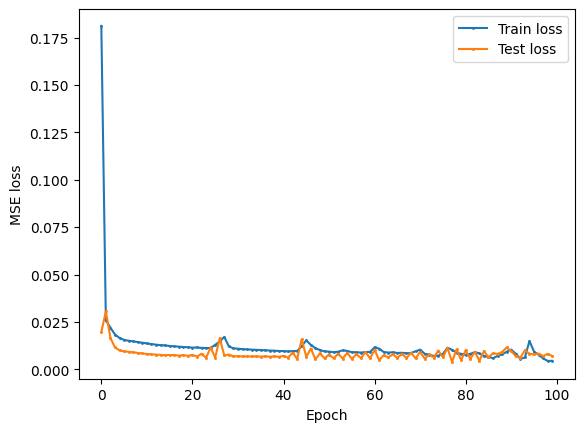

In [14]:
def loss_list():
    plt.plot(dast_model.train_loss_list, label='Train loss', marker='o', markersize=1)
    plt.plot(dast_model.test_loss_list, label='Test loss', marker='s', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()
loss_list()

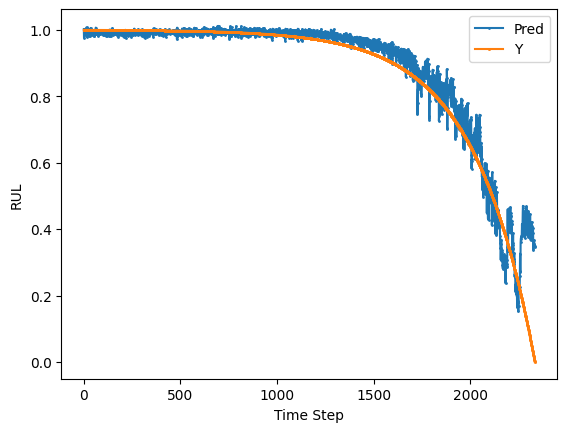

In [15]:
def best_predict():
    plt.plot(dast_model.best_predict, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
best_predict()

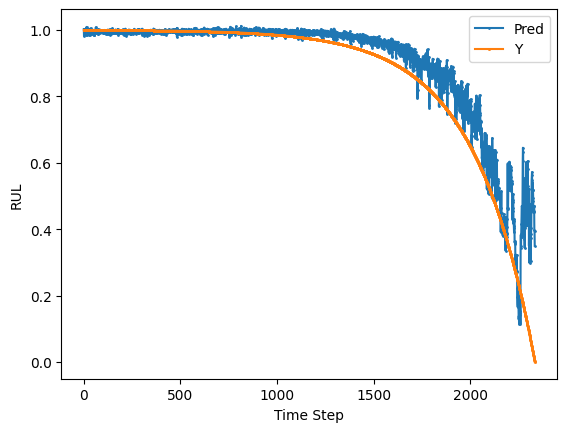

In [18]:
def last_predict_vs_y():
    last_predict_y = np.reshape(dast_model.last_predict_y, (-1))
    last_predict_y = last_predict_y.tolist()
    plt.plot(last_predict_y, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
last_predict_vs_y()

In [17]:
dast_model.best_mse_loss

0.0038819764740765095

In [ ]:
# run above

# RUN above

In [ ]:
import matplotlib.pyplot as plt
# Example data
X_draw = X_train[:2763, 0, 4]
# Plotting the line chart
plt.plot(X_draw, label='Pred', marker='o', markersize=1)
# plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Bearing 1-1 Horizontal Vibration Signal')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(X_train[0], label='Pred', marker='o', markersize=1)
plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
    plt.plot(X_train_1[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_1[:, 0, i]), max(X_train_1[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-1 Feature {i+1}')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_2[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_2[:, 0, i]), max(X_train_2[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-2 Feature {i+1}')
    # Display the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_3[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_3[:, 0, i]), max(X_train_3[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-4 Feature {i+1}')
    # Display the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_test[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_test[:, 0, i]), max(X_test[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-3 Feature {i+1}')
    # Display the plot
    plt.show()